In [1]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import time


## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed
gdrive = "."

In [2]:
print(tf.__version__)
print(tf.keras.__version__)

2.10.1
2.10.0


In [3]:
# SEM GPU é muito mais rápido e dá menos erro
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
#data generator class
class DataGen(keras.utils.Sequence):
    def __init__(self, train_ids, train_path, batch_size=3, image_size=256):
        self.ids = train_ids;
        self.path = train_path;
        self.batch_size = batch_size;
        self.image_size = image_size;
        self.on_epoch_end();
        
    def __load__(self, id_name):
        #defining path for the training data set
        
        id_name_mask = id_name.replace(".JPG",".png").replace(".jpg",".png")
        

        image_path = os.path.join(self.path, "images", id_name);
        mask_path = os.path.join(self.path, "masks", id_name_mask); #mascaras estao em .png
        
        # reading the image from dataset
        ## Reading Image
        image = cv2.imread(image_path, 1); #reading image to image vaiable
        image = cv2.resize(image, (self.image_size, self.image_size));
        mask = cv2.imread(mask_path, 0); #mask image of same size with all zeros
        mask = cv2.resize(mask, (self.image_size ,self.image_size));
        mask = np.expand_dims(mask, axis=-1);
        #image normalisation
        image = image / 255.0;
        mask = mask / 255.0;
        
        return image, mask;
    
    def __getitem__(self, index): #index : batch no.
        
        if(index+1)*self.batch_size > len(self.ids): # redining last batch size
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size] #list of 10 image ids
        
        image = [] #collection of 10 images
        mask  = [] #collection of 10 masks
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name);
            image.append(_img);
            mask.append(_mask);
            
        image = np.array(image);
        mask  = np.array(mask);
        
        return image, mask; #return array of 10 images and 10 masks
    
    #for printing the statistics of the function
    def on_epoch_end(self):
        print("epoch completed");
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)));#length of the epoch as length of generation DataGen obj

In [5]:

#hyperparameter
image_size = 256;

#ATENCAO 512 trava o PC


#train_path = gdrive + "/malaria_broadinstitute_relabeled-unet/"; #address of the dataset
#train_path = "../pyAnnotation/malaria_broadinstitute_relabeled-11-masks/"; #address of the dataset
train_path = gdrive + "/data-1024x1024 remade/"; #address of the dataset
#train_path = gdrive + "/data-1024x1024/"; #address of the dataset
epochs = 3000; #number of time we need to train dataset
batch_size = 10; #tarining batch size

#train path
train_ids = os.listdir(train_path + "/images")
#Validation Data Size
val_data_size = 1; #size of set of images used for the validation 

valid_ids = train_ids[:val_data_size]; # list of image ids used for validation of result 0 to 9
train_ids = train_ids[val_data_size:]; #list of image ids used for training dataset
#print(valid_ids, "\n\n");
print("training_size: ", len(train_ids), "validation_size: ", len(valid_ids))

#making generator object
gen = DataGen(train_ids, train_path, batch_size, image_size);
print("total epoch: ", len(gen))
#print(valid_ids)

training_size:  19 validation_size:  1
epoch completed
total epoch:  2


shape of the batch (10, 256, 256, 3) (10, 256, 256, 1)
Number of images in the batch:  10


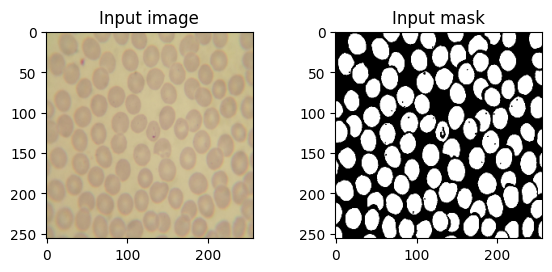

In [6]:
#Analysing sample of the dataset from data generator


#getting image_set data from dataset
x, y = gen.__getitem__(0); # self = gen and index = 0 each item is a set of 8 images
print("shape of the batch", x.shape, y.shape);
print("Number of images in the batch: ", len(x));

#display of the sample of the data zeroth image

fig = plt.figure();
fig.subplots_adjust(hspace=0.4, wspace=0.4); #reserving height above plot and space between plots
ax = fig.add_subplot(1, 2, 1); #figure of 1 row 2 columns and 1st image
x1 = (x[2]*255).astype(np.uint8);
x1 = cv2.cvtColor(x1, cv2.COLOR_BGR2RGB);
ax.imshow(x1);
plt.title("Input image");

ax = fig.add_subplot(1, 2, 2); #2nd image plot
ax.imshow(np.reshape(y[2], (image_size, image_size)), cmap="gray");
plt.title("Input mask");

In [7]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [8]:
def UNet(size):
    if (size == 128):
        return UNet128()
    elif (size == 256):
        return UNet256()
    elif (size == 512):
        return UNet512()
    elif (size == 1024):
        return UNet1024()
    
def UNet1024():
    f = [16, 32, 64, 128, 256, 512, 1024, 2048]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #pooling layer downsmaples 128 image to 512
    c2, p2 = down_block(p1, f[1]) #pooling layer downsmaples 128 image to 256
    c3, p3 = down_block(p2, f[2]) #pooling layer downsmaples 128 image to 128
    c4, p4 = down_block(p3, f[3]) #pooling layer downsmaples 128 image to 64
    c5, p5 = down_block(p4, f[4]) #pooling layer downsmaples 128 image to 32
    c6, p6 = down_block(p5, f[5]) #pooling layer downsmaples 128 image to 16
    c7, p7 = down_block(p6, f[6]) #pooling layer downsmaples 128 image to 8
    
    bn = bottleneck(p7, f[7])
    
    u1 = up_block(bn, c7, f[6]) #upsampling layer upsmaples 8 image to 16
    u2 = up_block(u1, c6, f[5]) #upsampling layer upsmaples 8 image to 32
    u3 = up_block(u2, c5, f[4]) #upsampling layer upsmaples 8 image to 64
    u4 = up_block(u3, c4, f[3]) #upsampling layer upsmaples 8 image to 128
    u5 = up_block(u4, c3, f[2]) #upsampling layer upsmaples 8 image to 256
    u6 = up_block(u5, c2, f[1]) #upsampling layer upsmaples 8 image to 512
    u7 = up_block(u6, c1, f[0]) #upsampling layer upsmaples 8 image to 512
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u7)
    model = keras.models.Model(inputs, outputs)
    return model
    

#unet model
def UNet512():
    f = [16, 32, 64, 128, 256, 512, 1024]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0], kernel_size=(15,15)) #pooling layer downsmaples 128 image to 256
    c2, p2 = down_block(p1, f[1]) #pooling layer downsmaples 128 image to 128
    c3, p3 = down_block(p2, f[2]) #pooling layer downsmaples 128 image to 64
    c4, p4 = down_block(p3, f[3]) #pooling layer downsmaples 128 image to 32
    c5, p5 = down_block(p4, f[4]) #pooling layer downsmaples 128 image to 16
    c6, p6 = down_block(p5, f[5]) #pooling layer downsmaples 128 image to 8
    
    bn = bottleneck(p6, f[6])
    
    u1 = up_block(bn, c6, f[5]) #upsampling layer upsmaples 8 image to 16
    u2 = up_block(u1, c5, f[4]) #upsampling layer upsmaples 8 image to 32
    u3 = up_block(u2, c4, f[3]) #upsampling layer upsmaples 8 image to 64
    u4 = up_block(u3, c3, f[2]) #upsampling layer upsmaples 8 image to 128
    u5 = up_block(u4, c2, f[1]) #upsampling layer upsmaples 8 image to 256
    u6 = up_block(u5, c1, f[0], kernel_size=(15,15)) #upsampling layer upsmaples 8 image to 512
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u6)
    model = keras.models.Model(inputs, outputs)
    return model

def UNet256():
    f = [16, 32, 64, 128, 256, 512]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #pooling layer downsmaples 128 image to 128
    c2, p2 = down_block(p1, f[1]) #pooling layer downsmaples 128 image to 64
    c3, p3 = down_block(p2, f[2]) #pooling layer downsmaples 128 image to 32
    c4, p4 = down_block(p3, f[3]) #pooling layer downsmaples 128 image to 16
    c5, p5 = down_block(p4, f[4]) #pooling layer downsmaples 128 image to 8
    
    bn = bottleneck(p5, f[5])
    
    u1 = up_block(bn, c5, f[4]) #upsampling layer upsmaples 8 image to 16
    u2 = up_block(u1, c4, f[3]) #upsampling layer upsmaples 8 image to 32
    u3 = up_block(u2, c3, f[2]) #upsampling layer upsmaples 8 image to 64
    u4 = up_block(u3, c2, f[1]) #upsampling layer upsmaples 8 image to 128
    u5 = up_block(u4, c1, f[0]) #upsampling layer upsmaples 8 image to 256
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u5)
    model = keras.models.Model(inputs, outputs)
    return model


def UNet128():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #pooling layer downsmaples 128 image to 64
    c2, p2 = down_block(p1, f[1]) #pooling layer downsmaples 128 image to 32
    c3, p3 = down_block(p2, f[2]) #pooling layer downsmaples 128 image to 16
    c4, p4 = down_block(p3, f[3]) #pooling layer downsmaples 128 image to 8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #upsampling layer upsmaples 8 image to 16
    u2 = up_block(u1, c3, f[2]) #upsampling layer upsmaples 8 image to 32
    u3 = up_block(u2, c2, f[1]) #upsampling layer upsmaples 8 image to 64
    u4 = up_block(u3, c1, f[0]) #upsampling layer upsmaples 8 image to 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

def impHistoria(history):
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.title('train loss'); plt.ylabel('MSE loss'); plt.xlabel('epoch')
    plt.legend(['train loss'], loc='upper left')
    plt.show()
    plt.plot(history.history['acc'])
    plt.title('train accuracy'); plt.ylabel('accuracy'); plt.xlabel('epoch')
    plt.legend(['train accuracy'], loc='upper left')
    plt.show()

In [9]:
print(image_size)
model = UNet(image_size)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

256
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                         

                                                                                                  
 up_sampling2d_4 (UpSampling2D)  (None, 256, 256, 32  0          ['conv2d_19[0][0]']              
                                )                                                                 
                                                                                                  
 concatenate_4 (Concatenate)    (None, 256, 256, 48  0           ['up_sampling2d_4[0][0]',        
                                )                                 'conv2d_1[0][0]']               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 16  6928        ['concatenate_4[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_21

In [10]:
batch_size = 10
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size);
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size);
print("total training batches: ", len(train_gen));
print("total validaton batches: ", len(valid_gen));
train_steps = len(train_ids)//batch_size;
valid_steps = len(valid_ids)//batch_size;
print("image_size:", image_size)
epochs = 1000
print(epochs)
versao = 1

_fileName = gdrive + "/cells-s%d-e%d-v%d-tf241.h5"
filename = _fileName % (image_size, epochs, versao)

print("filename:",filename)

epoch completed
epoch completed
total training batches:  2
total validaton batches:  1
image_size: 256
1000
filename: ./cells-s256-e1000-v1-tf241.h5


Epoch 1/1000
1/1 [==============================] - 3s 3s/step - loss: 0.6937 - acc: 0.4544
epoch completed
Epoch 2/1000
1/1 [==============================] - 0s 290ms/step - loss: 0.6925 - acc: 0.5181
epoch completed
Epoch 3/1000
1/1 [==============================] - 0s 272ms/step - loss: 0.6928 - acc: 0.5097
epoch completed
Epoch 4/1000
1/1 [==============================] - 0s 280ms/step - loss: 0.6947 - acc: 0.3963
epoch completed
Epoch 5/1000
1/1 [==============================] - 0s 285ms/step - loss: 0.6925 - acc: 0.4686
epoch completed
Epoch 6/1000
1/1 [==============================] - 0s 295ms/step - loss: 0.6926 - acc: 0.6709
epoch completed
Epoch 7/1000
1/1 [==============================] - 0s 285ms/step - loss: 0.6922 - acc: 0.5186
epoch completed
Epoch 8/1000
1/1 [==============================] - 0s 282ms/step - loss: 0.6937 - acc: 0.4617
epoch completed
Epoch 9/1000
1/1 [==============================] - 0s 300ms/step - loss: 0.6928 - acc: 0.4873
epoch completed
Epoc

1/1 [==============================] - 0s 269ms/step - loss: 0.6926 - acc: 0.4513
epoch completed
Epoch 42/1000
1/1 [==============================] - 0s 301ms/step - loss: 0.6923 - acc: 0.4593
epoch completed
Epoch 43/1000
1/1 [==============================] - 0s 313ms/step - loss: 0.6935 - acc: 0.4496
epoch completed
Epoch 44/1000
1/1 [==============================] - 0s 307ms/step - loss: 0.6931 - acc: 0.4447
epoch completed
Epoch 45/1000
1/1 [==============================] - 0s 306ms/step - loss: 0.6921 - acc: 0.4623
epoch completed
Epoch 46/1000
1/1 [==============================] - 0s 294ms/step - loss: 0.6938 - acc: 0.4146
epoch completed
Epoch 47/1000
1/1 [==============================] - 0s 288ms/step - loss: 0.6921 - acc: 0.6405
epoch completed
Epoch 48/1000
1/1 [==============================] - 0s 287ms/step - loss: 0.6931 - acc: 0.3378
epoch completed
Epoch 49/1000
1/1 [==============================] - 0s 288ms/step - loss: 0.6918 - acc: 0.4588
epoch completed
Epoch 

1/1 [==============================] - 0s 303ms/step - loss: 0.6790 - acc: 0.5246
epoch completed
Epoch 82/1000
1/1 [==============================] - 0s 298ms/step - loss: 0.6807 - acc: 0.5322
epoch completed
Epoch 83/1000
1/1 [==============================] - 0s 332ms/step - loss: 0.6816 - acc: 0.8937
epoch completed
Epoch 84/1000
1/1 [==============================] - 0s 327ms/step - loss: 0.6761 - acc: 0.4615
epoch completed
Epoch 85/1000
1/1 [==============================] - 0s 355ms/step - loss: 0.6743 - acc: 0.4591
epoch completed
Epoch 86/1000
1/1 [==============================] - 0s 307ms/step - loss: 0.6645 - acc: 0.4788
epoch completed
Epoch 87/1000
1/1 [==============================] - 0s 341ms/step - loss: 0.6580 - acc: 0.8678
epoch completed
Epoch 88/1000
1/1 [==============================] - 0s 355ms/step - loss: 0.6516 - acc: 0.6046
epoch completed
Epoch 89/1000
1/1 [==============================] - 0s 385ms/step - loss: 0.6355 - acc: 0.5709
epoch completed
Epoch 

1/1 [==============================] - 0s 322ms/step - loss: 0.6230 - acc: 0.7931
epoch completed
Epoch 122/1000
1/1 [==============================] - 0s 323ms/step - loss: 0.6119 - acc: 0.5624
epoch completed
Epoch 123/1000
1/1 [==============================] - 0s 345ms/step - loss: 0.5793 - acc: 0.7837
epoch completed
Epoch 124/1000
1/1 [==============================] - 0s 376ms/step - loss: 0.5618 - acc: 0.7843
epoch completed
Epoch 125/1000
1/1 [==============================] - 0s 349ms/step - loss: 0.8904 - acc: 0.5408
epoch completed
Epoch 126/1000
1/1 [==============================] - 0s 311ms/step - loss: 0.6560 - acc: 0.6150
epoch completed
Epoch 127/1000
1/1 [==============================] - 0s 318ms/step - loss: 0.6075 - acc: 0.6637
epoch completed
Epoch 128/1000
1/1 [==============================] - 0s 333ms/step - loss: 0.5703 - acc: 0.7863
epoch completed
Epoch 129/1000
1/1 [==============================] - 0s 322ms/step - loss: 0.6124 - acc: 0.7055
epoch complete

1/1 [==============================] - 0s 336ms/step - loss: 0.5033 - acc: 0.7508
epoch completed
Epoch 162/1000
1/1 [==============================] - 0s 360ms/step - loss: 0.4959 - acc: 0.7635
epoch completed
Epoch 163/1000
1/1 [==============================] - 0s 324ms/step - loss: 0.4941 - acc: 0.7650
epoch completed
Epoch 164/1000
1/1 [==============================] - 0s 346ms/step - loss: 0.4839 - acc: 0.8238
epoch completed
Epoch 165/1000
1/1 [==============================] - 0s 338ms/step - loss: 0.5675 - acc: 0.7095
epoch completed
Epoch 166/1000
1/1 [==============================] - 0s 341ms/step - loss: 0.4953 - acc: 0.7520
epoch completed
Epoch 167/1000
1/1 [==============================] - 0s 372ms/step - loss: 0.4905 - acc: 0.7680
epoch completed
Epoch 168/1000
1/1 [==============================] - 0s 337ms/step - loss: 0.5047 - acc: 0.6937
epoch completed
Epoch 169/1000
1/1 [==============================] - 0s 305ms/step - loss: 0.4639 - acc: 0.7713
epoch complete

1/1 [==============================] - 0s 354ms/step - loss: 0.4112 - acc: 0.8083
epoch completed
Epoch 202/1000
1/1 [==============================] - 0s 338ms/step - loss: 0.4513 - acc: 0.7817
epoch completed
Epoch 203/1000
1/1 [==============================] - 0s 273ms/step - loss: 0.4100 - acc: 0.8100
epoch completed
Epoch 204/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.3808 - acc: 0.8459
epoch completed
Epoch 205/1000
1/1 [==============================] - 0s 316ms/step - loss: 0.4895 - acc: 0.7644
epoch completed
Epoch 206/1000
1/1 [==============================] - 0s 334ms/step - loss: 0.4752 - acc: 0.8179
epoch completed
Epoch 207/1000
1/1 [==============================] - 0s 311ms/step - loss: 0.3257 - acc: 0.9030
epoch completed
Epoch 208/1000
1/1 [==============================] - 0s 318ms/step - loss: 0.4022 - acc: 0.8291
epoch completed
Epoch 209/1000
1/1 [==============================] - 0s 336ms/step - loss: 0.4534 - acc: 0.7830
epoch complete

1/1 [==============================] - 0s 284ms/step - loss: 0.3469 - acc: 0.8351
epoch completed
Epoch 242/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.2964 - acc: 0.8685
epoch completed
Epoch 243/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.2117 - acc: 0.9239
epoch completed
Epoch 244/1000
1/1 [==============================] - 0s 312ms/step - loss: 0.3438 - acc: 0.8360
epoch completed
Epoch 245/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.2046 - acc: 0.9262
epoch completed
Epoch 246/1000
1/1 [==============================] - 0s 299ms/step - loss: 0.2822 - acc: 0.8866
epoch completed
Epoch 247/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.3591 - acc: 0.8286
epoch completed
Epoch 248/1000
1/1 [==============================] - 0s 299ms/step - loss: 0.3070 - acc: 0.8573
epoch completed
Epoch 249/1000
1/1 [==============================] - 0s 292ms/step - loss: 0.1855 - acc: 0.9191
epoch complete

1/1 [==============================] - 0s 283ms/step - loss: 0.2974 - acc: 0.8736
epoch completed
Epoch 282/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.2877 - acc: 0.8665
epoch completed
Epoch 283/1000
1/1 [==============================] - 0s 299ms/step - loss: 0.3822 - acc: 0.8260
epoch completed
Epoch 284/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.2984 - acc: 0.8690
epoch completed
Epoch 285/1000
1/1 [==============================] - 0s 285ms/step - loss: 0.3583 - acc: 0.8248
epoch completed
Epoch 286/1000
1/1 [==============================] - 0s 292ms/step - loss: 0.1996 - acc: 0.9200
epoch completed
Epoch 287/1000
1/1 [==============================] - 0s 266ms/step - loss: 0.3514 - acc: 0.8305
epoch completed
Epoch 288/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.2716 - acc: 0.8908
epoch completed
Epoch 289/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.3352 - acc: 0.8374
epoch complete

1/1 [==============================] - 0s 284ms/step - loss: 0.3581 - acc: 0.8302
epoch completed
Epoch 322/1000
1/1 [==============================] - 0s 285ms/step - loss: 0.2870 - acc: 0.8634
epoch completed
Epoch 323/1000
1/1 [==============================] - 0s 286ms/step - loss: 0.2621 - acc: 0.8789
epoch completed
Epoch 324/1000
1/1 [==============================] - 0s 298ms/step - loss: 0.3284 - acc: 0.8381
epoch completed
Epoch 325/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.2852 - acc: 0.8635
epoch completed
Epoch 326/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.2213 - acc: 0.8988
epoch completed
Epoch 327/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.3429 - acc: 0.8449
epoch completed
Epoch 328/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.2894 - acc: 0.8690
epoch completed
Epoch 329/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.1862 - acc: 0.9175
epoch complete

1/1 [==============================] - 0s 281ms/step - loss: 0.2479 - acc: 0.8769
epoch completed
Epoch 362/1000
1/1 [==============================] - 0s 282ms/step - loss: 0.2470 - acc: 0.8868
epoch completed
Epoch 363/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.2089 - acc: 0.8953
epoch completed
Epoch 364/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.3088 - acc: 0.8503
epoch completed
Epoch 365/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.3084 - acc: 0.8482
epoch completed
Epoch 366/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.1939 - acc: 0.9126
epoch completed
Epoch 367/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.2562 - acc: 0.8768
epoch completed
Epoch 368/1000
1/1 [==============================] - 0s 284ms/step - loss: 0.1981 - acc: 0.9097
epoch completed
Epoch 369/1000
1/1 [==============================] - 0s 282ms/step - loss: 0.3158 - acc: 0.8439
epoch complete

1/1 [==============================] - 0s 281ms/step - loss: 0.2781 - acc: 0.8748
epoch completed
Epoch 402/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.2572 - acc: 0.8828
epoch completed
Epoch 403/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.3171 - acc: 0.8381
epoch completed
Epoch 404/1000
1/1 [==============================] - 0s 284ms/step - loss: 0.1951 - acc: 0.9130
epoch completed
Epoch 405/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.2343 - acc: 0.8926
epoch completed
Epoch 406/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1803 - acc: 0.9185
epoch completed
Epoch 407/1000
1/1 [==============================] - 0s 268ms/step - loss: 0.2012 - acc: 0.9137
epoch completed
Epoch 408/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1690 - acc: 0.9199
epoch completed
Epoch 409/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.2606 - acc: 0.8806
epoch complete

1/1 [==============================] - 0s 281ms/step - loss: 0.2661 - acc: 0.8653
epoch completed
Epoch 442/1000
1/1 [==============================] - 0s 282ms/step - loss: 0.3034 - acc: 0.8487
epoch completed
Epoch 443/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.1945 - acc: 0.9147
epoch completed
Epoch 444/1000
1/1 [==============================] - 0s 282ms/step - loss: 0.3156 - acc: 0.8476
epoch completed
Epoch 445/1000
1/1 [==============================] - 0s 284ms/step - loss: 0.1621 - acc: 0.9215
epoch completed
Epoch 446/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.2202 - acc: 0.8932
epoch completed
Epoch 447/1000
1/1 [==============================] - 0s 284ms/step - loss: 0.2849 - acc: 0.8631
epoch completed
Epoch 448/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1838 - acc: 0.9127
epoch completed
Epoch 449/1000
1/1 [==============================] - 0s 282ms/step - loss: 0.1904 - acc: 0.9111
epoch complete

1/1 [==============================] - 0s 283ms/step - loss: 0.2812 - acc: 0.8576
epoch completed
Epoch 482/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1712 - acc: 0.9189
epoch completed
Epoch 483/1000
1/1 [==============================] - 0s 284ms/step - loss: 0.2804 - acc: 0.8598
epoch completed
Epoch 484/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.2287 - acc: 0.8925
epoch completed
Epoch 485/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.1751 - acc: 0.9270
epoch completed
Epoch 486/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1690 - acc: 0.9189
epoch completed
Epoch 487/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.1568 - acc: 0.9227
epoch completed
Epoch 488/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.2124 - acc: 0.8965
epoch completed
Epoch 489/1000
1/1 [==============================] - 0s 267ms/step - loss: 0.1968 - acc: 0.8988
epoch complete

1/1 [==============================] - 0s 284ms/step - loss: 0.1387 - acc: 0.9265
epoch completed
Epoch 522/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1237 - acc: 0.9284
epoch completed
Epoch 523/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.0929 - acc: 0.9487
epoch completed
Epoch 524/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.2933 - acc: 0.8799
epoch completed
Epoch 525/1000
1/1 [==============================] - 0s 298ms/step - loss: 0.2452 - acc: 0.8798
epoch completed
Epoch 526/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1342 - acc: 0.9282
epoch completed
Epoch 527/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.1481 - acc: 0.9222
epoch completed
Epoch 528/1000
1/1 [==============================] - 0s 286ms/step - loss: 0.2604 - acc: 0.8778
epoch completed
Epoch 529/1000
1/1 [==============================] - 0s 272ms/step - loss: 0.1399 - acc: 0.9246
epoch complete

1/1 [==============================] - 0s 283ms/step - loss: 0.2369 - acc: 0.8800
epoch completed
Epoch 562/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1956 - acc: 0.8988
epoch completed
Epoch 563/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.2296 - acc: 0.8754
epoch completed
Epoch 564/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1141 - acc: 0.9406
epoch completed
Epoch 565/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.2443 - acc: 0.8800
epoch completed
Epoch 566/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.1716 - acc: 0.9070
epoch completed
Epoch 567/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.2533 - acc: 0.8746
epoch completed
Epoch 568/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.2354 - acc: 0.8820
epoch completed
Epoch 569/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.0922 - acc: 0.9488
epoch complete

1/1 [==============================] - 0s 275ms/step - loss: 0.1584 - acc: 0.9182
epoch completed
Epoch 602/1000
1/1 [==============================] - 0s 268ms/step - loss: 0.1539 - acc: 0.9195
epoch completed
Epoch 603/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1957 - acc: 0.8989
epoch completed
Epoch 604/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.2216 - acc: 0.8879
epoch completed
Epoch 605/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.2340 - acc: 0.8696
epoch completed
Epoch 606/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.2307 - acc: 0.8834
epoch completed
Epoch 607/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1165 - acc: 0.9368
epoch completed
Epoch 608/1000
1/1 [==============================] - 0s 268ms/step - loss: 0.1134 - acc: 0.9377
epoch completed
Epoch 609/1000
1/1 [==============================] - 0s 282ms/step - loss: 0.2146 - acc: 0.8926
epoch complete

1/1 [==============================] - 0s 281ms/step - loss: 0.0814 - acc: 0.9529
epoch completed
Epoch 642/1000
1/1 [==============================] - 0s 282ms/step - loss: 0.1702 - acc: 0.9044
epoch completed
Epoch 643/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.2321 - acc: 0.8816
epoch completed
Epoch 644/1000
1/1 [==============================] - 0s 284ms/step - loss: 0.0847 - acc: 0.9525
epoch completed
Epoch 645/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1509 - acc: 0.9210
epoch completed
Epoch 646/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.1125 - acc: 0.9391
epoch completed
Epoch 647/1000
1/1 [==============================] - 0s 282ms/step - loss: 0.1809 - acc: 0.9060
epoch completed
Epoch 648/1000
1/1 [==============================] - 0s 279ms/step - loss: 0.2276 - acc: 0.8832
epoch completed
Epoch 649/1000
1/1 [==============================] - 0s 268ms/step - loss: 0.2162 - acc: 0.8897
epoch complete

1/1 [==============================] - 0s 320ms/step - loss: 0.0800 - acc: 0.9530
epoch completed
Epoch 682/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1031 - acc: 0.9432
epoch completed
Epoch 683/1000
1/1 [==============================] - 0s 285ms/step - loss: 0.1975 - acc: 0.8969
epoch completed
Epoch 684/1000
1/1 [==============================] - 0s 299ms/step - loss: 0.0734 - acc: 0.9558
epoch completed
Epoch 685/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.0723 - acc: 0.9564
epoch completed
Epoch 686/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.2041 - acc: 0.9055
epoch completed
Epoch 687/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.2481 - acc: 0.8816
epoch completed
Epoch 688/1000
1/1 [==============================] - 0s 300ms/step - loss: 0.1049 - acc: 0.9403
epoch completed
Epoch 689/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.2174 - acc: 0.8895
epoch complete

1/1 [==============================] - 0s 313ms/step - loss: 0.0933 - acc: 0.9410
epoch completed
Epoch 722/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1851 - acc: 0.9061
epoch completed
Epoch 723/1000
1/1 [==============================] - 0s 298ms/step - loss: 0.1817 - acc: 0.9041
epoch completed
Epoch 724/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.1111 - acc: 0.9402
epoch completed
Epoch 725/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.1017 - acc: 0.9423
epoch completed
Epoch 726/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1122 - acc: 0.9355
epoch completed
Epoch 727/1000
1/1 [==============================] - 0s 299ms/step - loss: 0.2193 - acc: 0.8887
epoch completed
Epoch 728/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1061 - acc: 0.9426
epoch completed
Epoch 729/1000
1/1 [==============================] - 0s 300ms/step - loss: 0.1109 - acc: 0.9380
epoch complete

1/1 [==============================] - 0s 312ms/step - loss: 0.1084 - acc: 0.9385
epoch completed
Epoch 762/1000
1/1 [==============================] - 0s 284ms/step - loss: 0.2157 - acc: 0.8895
epoch completed
Epoch 763/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.0991 - acc: 0.9436
epoch completed
Epoch 764/1000
1/1 [==============================] - 0s 299ms/step - loss: 0.0844 - acc: 0.9494
epoch completed
Epoch 765/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1551 - acc: 0.9151
epoch completed
Epoch 766/1000
1/1 [==============================] - 0s 298ms/step - loss: 0.1785 - acc: 0.9056
epoch completed
Epoch 767/1000
1/1 [==============================] - 0s 298ms/step - loss: 0.1750 - acc: 0.9069
epoch completed
Epoch 768/1000
1/1 [==============================] - 0s 278ms/step - loss: 0.1069 - acc: 0.9376
epoch completed
Epoch 769/1000
1/1 [==============================] - 0s 282ms/step - loss: 0.2301 - acc: 0.8833
epoch complete

1/1 [==============================] - 0s 314ms/step - loss: 0.0953 - acc: 0.9429
epoch completed
Epoch 802/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.1650 - acc: 0.9077
epoch completed
Epoch 803/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.0708 - acc: 0.9566
epoch completed
Epoch 804/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.1941 - acc: 0.8980
epoch completed
Epoch 805/1000
1/1 [==============================] - 0s 284ms/step - loss: 0.1607 - acc: 0.9138
epoch completed
Epoch 806/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1100 - acc: 0.9383
epoch completed
Epoch 807/1000
1/1 [==============================] - 0s 282ms/step - loss: 0.2098 - acc: 0.8887
epoch completed
Epoch 808/1000
1/1 [==============================] - 0s 288ms/step - loss: 0.0918 - acc: 0.9411
epoch completed
Epoch 809/1000
1/1 [==============================] - 0s 284ms/step - loss: 0.1420 - acc: 0.9201
epoch complete

1/1 [==============================] - 0s 300ms/step - loss: 0.1227 - acc: 0.9293
epoch completed
Epoch 842/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.1591 - acc: 0.9109
epoch completed
Epoch 843/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1424 - acc: 0.9199
epoch completed
Epoch 844/1000
1/1 [==============================] - 0s 284ms/step - loss: 0.1332 - acc: 0.9249
epoch completed
Epoch 845/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1139 - acc: 0.9335
epoch completed
Epoch 846/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.0768 - acc: 0.9518
epoch completed
Epoch 847/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1820 - acc: 0.9023
epoch completed
Epoch 848/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.0749 - acc: 0.9528
epoch completed
Epoch 849/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.0879 - acc: 0.9458
epoch complete

1/1 [==============================] - 0s 281ms/step - loss: 0.0880 - acc: 0.9424
epoch completed
Epoch 882/1000
1/1 [==============================] - 0s 280ms/step - loss: 0.1902 - acc: 0.8998
epoch completed
Epoch 883/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.1070 - acc: 0.9404
epoch completed
Epoch 884/1000
1/1 [==============================] - 0s 301ms/step - loss: 0.0956 - acc: 0.9438
epoch completed
Epoch 885/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1841 - acc: 0.9014
epoch completed
Epoch 886/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.0923 - acc: 0.9456
epoch completed
Epoch 887/1000
1/1 [==============================] - 0s 284ms/step - loss: 0.1217 - acc: 0.9304
epoch completed
Epoch 888/1000
1/1 [==============================] - 0s 266ms/step - loss: 0.0893 - acc: 0.9418
epoch completed
Epoch 889/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.1254 - acc: 0.9272
epoch complete

1/1 [==============================] - 0s 281ms/step - loss: 0.1491 - acc: 0.9158
epoch completed
Epoch 922/1000
1/1 [==============================] - 0s 284ms/step - loss: 0.1426 - acc: 0.9182
epoch completed
Epoch 923/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1148 - acc: 0.9332
epoch completed
Epoch 924/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.0991 - acc: 0.9434
epoch completed
Epoch 925/1000
1/1 [==============================] - 0s 291ms/step - loss: 0.0794 - acc: 0.9514
epoch completed
Epoch 926/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1793 - acc: 0.9031
epoch completed
Epoch 927/1000
1/1 [==============================] - 0s 300ms/step - loss: 0.0865 - acc: 0.9434
epoch completed
Epoch 928/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1103 - acc: 0.9334
epoch completed
Epoch 929/1000
1/1 [==============================] - 0s 280ms/step - loss: 0.0878 - acc: 0.9468
epoch complete

1/1 [==============================] - 0s 298ms/step - loss: 0.0643 - acc: 0.9588
epoch completed
Epoch 962/1000
1/1 [==============================] - 0s 282ms/step - loss: 0.1184 - acc: 0.9315
epoch completed
Epoch 963/1000
1/1 [==============================] - 0s 284ms/step - loss: 0.0815 - acc: 0.9461
epoch completed
Epoch 964/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1682 - acc: 0.9066
epoch completed
Epoch 965/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1105 - acc: 0.9355
epoch completed
Epoch 966/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.1479 - acc: 0.9152
epoch completed
Epoch 967/1000
1/1 [==============================] - 0s 284ms/step - loss: 0.0816 - acc: 0.9450
epoch completed
Epoch 968/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.1384 - acc: 0.9215
epoch completed
Epoch 969/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.1586 - acc: 0.9125
epoch complete

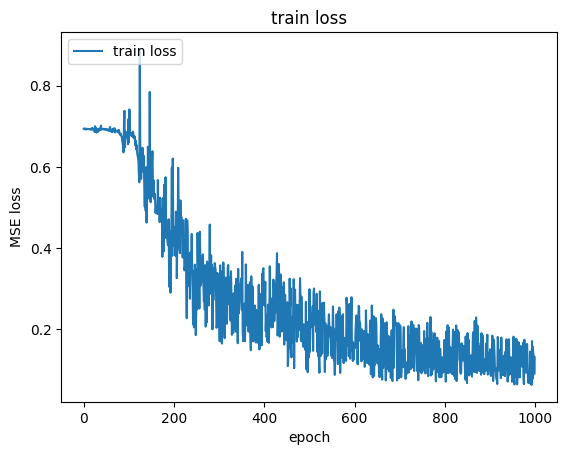

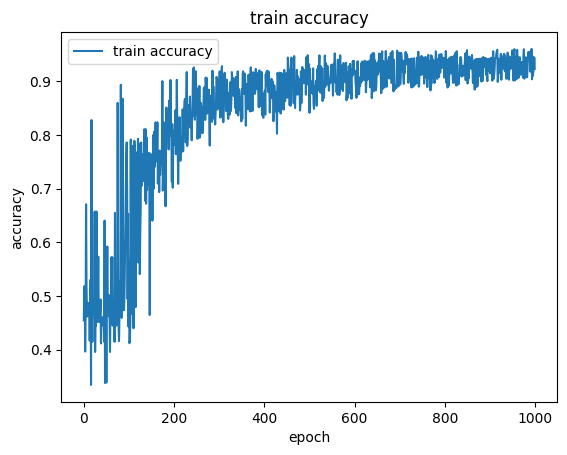

In [11]:
ini = time.time()

continueTrain = False
#continuar treino
if (continueTrain):
    filename = './cells-s512-e200-v1-tf241.h5'
    model = keras.models.load_model(filename);
    versao += 1


history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, 
                        validation_steps=valid_steps, epochs=epochs);
filename = _fileName % (image_size, epochs, versao)

fim = time.time()

print("Tempo:", fim-ini)

print("Horas:", (fim-ini)/60/60)
print(filename)
model.save(filename);
impHistoria(history)

In [13]:
#model = keras.models.load_model(filename);
#model = keras.models.load_model("cells-256-1000-30-v1.h5");
model.evaluate(valid_gen)

1/1 [==============================] - 0s 80ms/step - loss: 0.1411 - acc: 0.9236


[0.14111822843551636, 0.92364501953125]

# PREDICT

shape image:  (1, 256, 256, 3) shape mask:  (1, 256, 256, 1)
1/1 [==============================] - 0s 231ms/step
result_mask shape:  (1, 256, 256, 1)


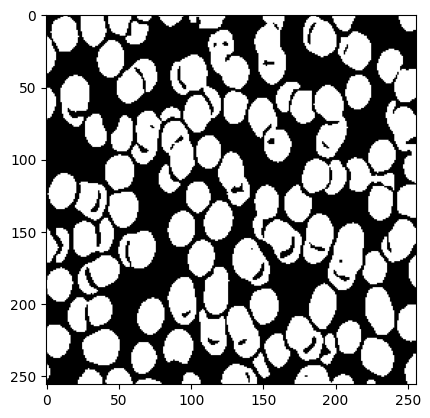

In [14]:

## Dataset for prediction
p_image, p_mask = train_gen.__getitem__(0); #accessed as normalised bool

print("shape image: ", p_image.shape, "shape mask: ", p_mask.shape)

result_mask = model.predict(p_image); #collection of 10 masks

print("result_mask shape: ", result_mask.shape);
result_mask = result_mask > 0.50; #float probability to bool conversion

plt.imshow(np.reshape(result_mask[0]*255, (image_size, image_size)), cmap="gray")
plt.show()




shape image:  (1, 256, 256, 3) shape mask:  (1, 256, 256, 1)
1/1 [==============================] - 0s 64ms/step
result_mask shape:  (1, 256, 256, 1)


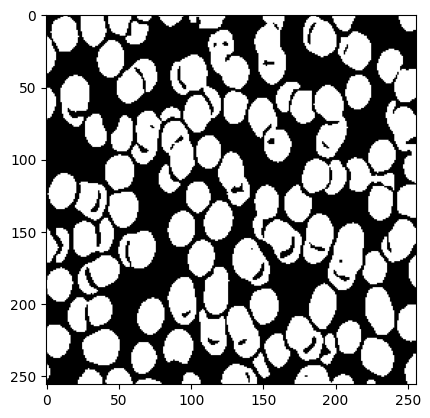

In [15]:

## Dataset for prediction
p_image, p_mask = train_gen.__getitem__(0); #accessed as normalised bool

print("shape image: ", p_image.shape, "shape mask: ", p_mask.shape)

result_mask = model.predict(p_image); #collection of 10 masks

print("result_mask shape: ", result_mask.shape);
result_mask = result_mask > 0.50; #float probability to bool conversion

plt.imshow(np.reshape(result_mask[0]*255, (image_size, image_size)), cmap="gray")
plt.show()




Text(0.5, 1.0, 'Predicted mask')

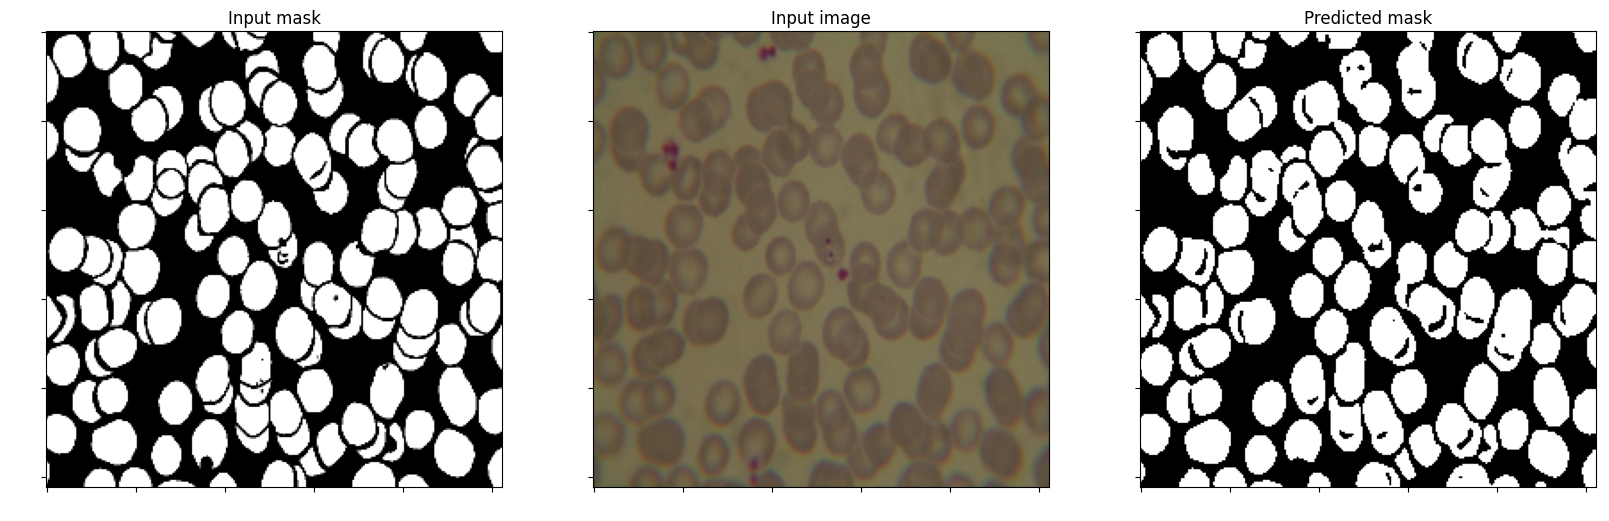

In [16]:


fig1 = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=.4, wspace=.6)
i = 0;
my_plot = fig1.add_subplot(1, 3, 1)
plt.title("Input mask")
plt.xticks(color='w')
plt.yticks(color='w')
my_plot.imshow(np.reshape(p_mask[i]*255, (image_size, image_size)), cmap="gray")

my_plot = fig1.add_subplot(1, 3, 2);
p_image2 = p_image[i][:,:,::-1]
my_plot.imshow(p_image2);
plt.xticks(color='w')
plt.yticks(color='w')
plt.title("Input image")

my_plot = fig1.add_subplot(1, 3, 3)
my_plot.imshow(np.reshape(result_mask[i]*255, (image_size, image_size)), cmap="gray")
plt.xticks(color='w')
plt.yticks(color='w')
plt.title("Predicted mask")

1/1 [==============================] - 0s 51ms/step
result_mask shape:  (1, 256, 256, 1)


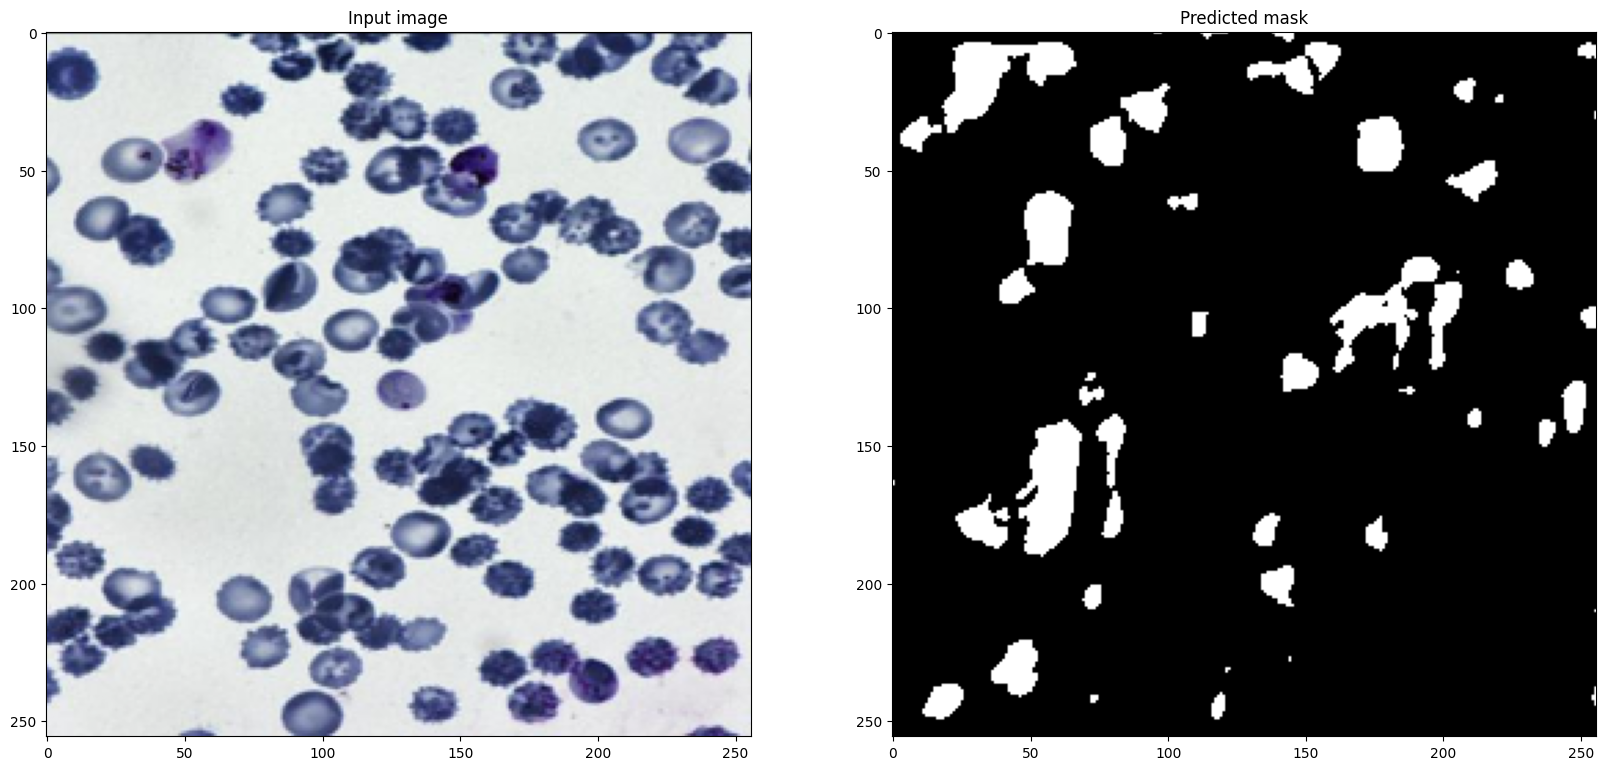

In [17]:
def load_img_norm(image_path, image_size):
        image = cv2.imread(image_path, 1); #reading image to image vaiable
        image = cv2.resize(image, (image_size, image_size));# resizing input image to 128 * 128
        #image normalisation
        image = image / 255.0;
        
        image_r = []
        image_r.append(image);
        image_r = np.array(image_r);
        return image_r;

## Dataset for prediction
#p_image = load_img_norm(gdrive+"/data-1024x1024/images/blood_smear_3.JPG",image_size)
p_image = load_img_norm("../pyAnnotation/malaria_broadinstitute_relabeled-1/train/images/03c8da48-04b9-4520-b674-44a0ecd35688_png.rf.1af68d1c0d903f6e5e13aa4ff2665e6e.jpg",image_size)


result_mask = model.predict(p_image); #collection of 10 masks

print("result_mask shape: ", result_mask.shape);

#plt.imshow(np.reshape(result_mask[0]*255, (image_size, image_size)), cmap="gray")
#plt.show()

result_mask = result_mask > 0.30; #float probability to bool conversion

fig, ax = plt.subplots(ncols=2, figsize=(20,20))

res = p_image[0][:,:,::-1]
ax[0].imshow(res);
ax[0].title.set_text("Input image")

ax[1].imshow(np.reshape(result_mask[0]*255, (image_size, image_size)), cmap="gray")
ax[1].title.set_text("Predicted mask")

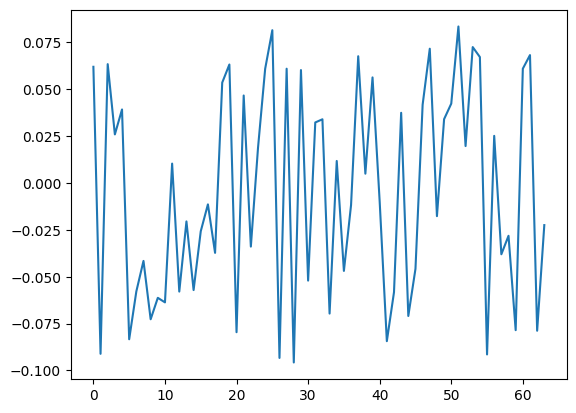

-0.09575534 0.08349238


In [88]:
inputs = keras.layers.Input((128, 128, 3))
c = keras.layers.Conv2D(64, (3,3), padding='same', strides=1, activation="relu")(inputs)
w = c.node.layer.get_weights()
w = w[0][0][0][0]
plt.plot(w)
plt.show()

print (min(w), max(w))

In [89]:
for i in range(10,31):
    image = cv2.imread(gdrive+"/data-1024x1024/masks/blood_smear_%d.png" % i)
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])

    print("blood_smear_%d.png" % i)
    hist /= hist.sum()
    for i in range(256):
        if hist[i][0] > 0:
            print(i,end=",")
    print("")


blood_smear_10.png
0,255,
blood_smear_11.png
0,255,
blood_smear_12.png
0,255,
blood_smear_13.png
0,255,
blood_smear_14.png
0,255,
blood_smear_15.png
0,255,
blood_smear_16.png
0,255,
blood_smear_17.png
0,255,
blood_smear_18.png
0,255,
blood_smear_19.png
0,255,
blood_smear_20.png
0,255,
blood_smear_21.png
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,2

0
3
22
23
24
29
31
32
33
34
37
38
41
42
47
48
49
50
51
54
55
58
61
62
63
64
65
66
68
70
71
74
76
78
80
81
82
83
84
85
86
88
89
90
91
92
94
95
97
98
99
100
102
103
105
108
109
110
112
114
115
116
118
119
120
122
124
125
127
128
129
131
134
135
136
137
140
143
146
147
150
153
154
155
157
159
160
161
162
163
165
166
167
168
169
170
174
175
176
177
178
179
180
181
182
184
186
188
189
191
192
193
194
195
196
198
200
203
204
205
206
207
209
210
211
212
215
217
218
219
220
222
223
224
225
226
229
230
231
232
233
239
240
241
242
243
244
245
246
247
248
249
250
252
253
254
255


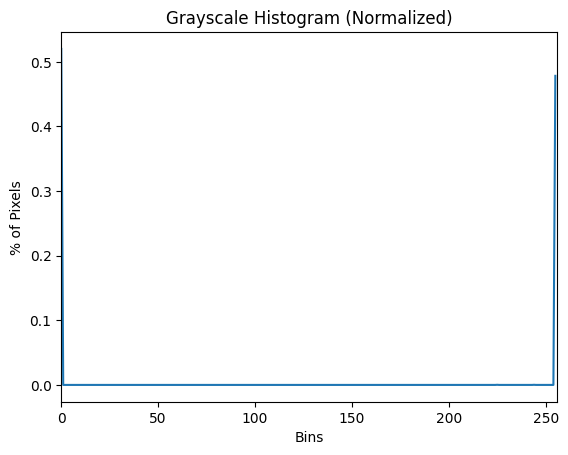

In [90]:
image = cv2.imread(gdrive+"/data-1024x1024/masks/blood_smear_1.png")
hist = cv2.calcHist([image], [0], None, [256], [0, 256])

hist /= hist.sum()
for i in range(256):
    if hist[i][0] > 0:
        print(i)
# plot the normalized histogram
plt.figure()
plt.title("Grayscale Histogram (Normalized)")
plt.xlabel("Bins")
plt.ylabel("% of Pixels")
plt.plot(hist)
plt.xlim([0, 256])
plt.show()